# Preprocessing for network construction from scBeta data

In [3]:
import scanpy as sc
import numpy as np
import pandas as pd
import os 
import os.path as op

In [4]:
in_dir = '/Users/smgroves/Documents/GitHub/Pancreas_BoBa/data/01_Stages_3_to_6/data/complete_processing/'
s3 = sc.read_loom(op.join(in_dir, 'x1_S3c.processed.loom'))
s4 = sc.read_loom(op.join(in_dir, 'x1_S4c.processed.loom'))
s5 = sc.read_loom(op.join(in_dir, 'x1_S5c.processed.loom'))
s6 = sc.read_loom(op.join(in_dir, 'x1_S6c.processed.loom'))




In [8]:
adata = s3.concatenate([s4,s5,s6],batch_key = 'stage',batch_categories=['s3', 's4','s5','s6'])

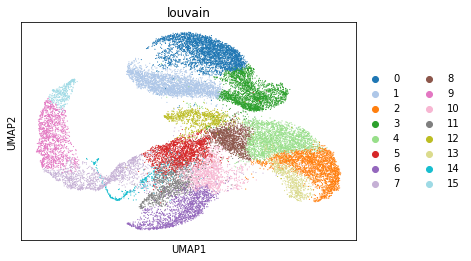

In [19]:
sc.pp.neighbors(adata)
sc.pp.pca(adata, n_comps=50)
sc.tl.umap(adata)
sc.tl.louvain(adata)
sc.pl.umap(adata, color='louvain', palette='tab20')

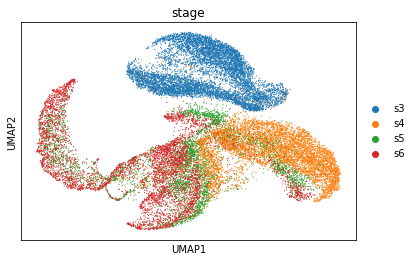

In [12]:
sc.pl.umap(adata, color = 'stage')

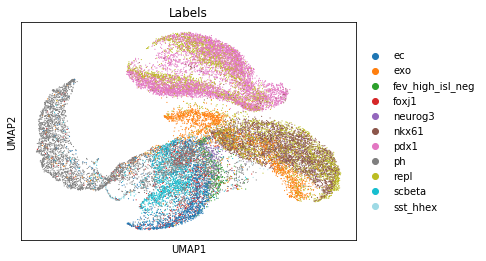

In [18]:
sc.pl.umap(adata, color = 'Labels', palette='tab20')

In [20]:
pd.crosstab(adata.obs['Labels'],adata.obs['stage'])

stage,s3,s4,s5,s6
Labels,,,,
ec,0,0,647,796
exo,0,0,1019,734
fev_high_isl_neg,0,352,0,0
foxj1,0,0,239,348
neurog3,0,388,0,0
nkx61,0,3507,0,0
pdx1,5955,0,0,0
ph,0,971,1392,2321
repl,2027,1687,267,135


In [21]:
pd.crosstab(adata.obs['Labels'],adata.obs['louvain'])

louvain,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Labels,,,,,,,,,,,,,,,,
ec,0,0,0,1,1,185,871,49,3,27,231,49,8,0,14,4
exo,1,10,38,12,125,73,12,61,151,15,15,7,729,495,4,5
fev_high_isl_neg,0,0,3,0,3,104,46,0,7,0,189,0,0,0,0,0
foxj1,0,0,4,0,1,140,237,35,4,17,102,35,1,0,8,3
neurog3,1,1,62,1,70,62,0,0,49,0,131,0,2,0,9,0
nkx61,11,9,1396,33,1353,10,0,2,673,0,4,0,10,3,3,0
pdx1,2258,1989,0,1708,0,0,0,0,0,0,0,0,0,0,0,0
ph,0,0,25,1,42,868,201,1149,55,1217,506,83,3,0,200,334
repl,913,657,769,502,608,26,6,10,391,1,7,0,81,142,2,1


In [27]:
adata

AnnData object with n_obs × n_vars = 24321 × 12879 
    obs: 'CellBatch', 'CellProtocol', 'CellStage', 'DetailedLabels', 'Labels', '_TrainFilter', '_Valid', 'stage', 'louvain', '__is_in_cluster__'
    var: '_Valid-s3', '_Valid-s4', '_Valid-s5', '_Valid-s6'
    uns: 'neighbors', 'louvain', 'pca', 'louvain_colors', 'stage_colors', 'Labels_colors', 'rank_genes_groups', 'dendrogram_stage', 'dendrogram_Labels', 'rank_genes_groups_filtered'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

## Rank genes for each group using Scanpy

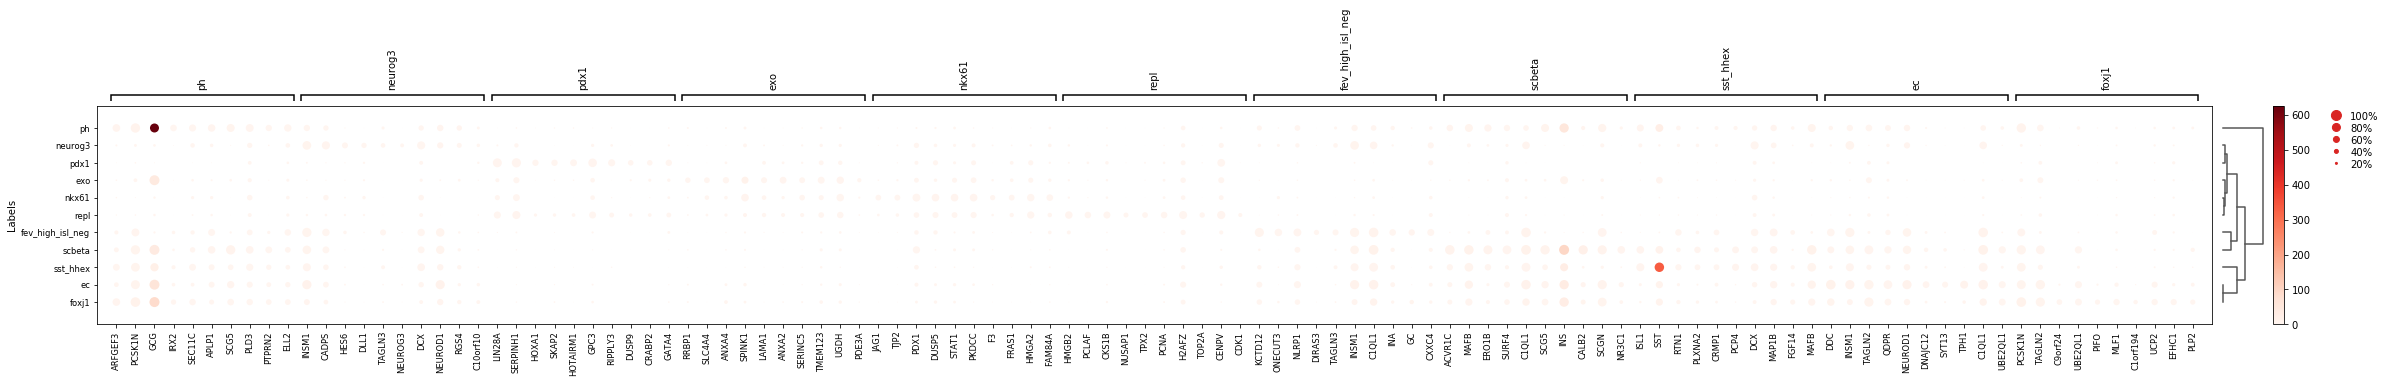

In [28]:
sc.tl.rank_genes_groups(adata, groupby='Labels', n_genes=200)
# sc.tl.filter_rank_genes_groups(adata, use_raw=False)
sc.pl.rank_genes_groups_dotplot(adata, key='rank_genes_groups_filtered')

In [34]:
master_tf_list = pd.read_csv('/Users/smgroves/Documents/GitHub/Pancreas_BoBa/data/master_tf_list.txt',
                            sep = '\t', header = 0, index_col=0)

""
gene_symbol
RNF14
RNF15
RNF16
RNF10
ZNF531


In [75]:
tfs = []
for i in adata.uns['rank_genes_groups']['names'][:20]:
    for j in i:
        if j in master_tf_list.index:
            tfs.append(j)
print(sorted(set(tfs)))

['CRABP2', 'ELL2', 'FOXA2', 'GATA4', 'HES6', 'HMGA1', 'HMGA2', 'HMGB1', 'HMGB2', 'HNRNPA3', 'HNRNPD', 'HOXA1', 'INSM1', 'IRX2', 'ISL1', 'LIN28A', 'MAFB', 'MLLT11', 'MNX1', 'NEUROD1', 'NEUROG3', 'NR3C1', 'ONECUT2', 'ONECUT3', 'PBX1', 'PCBD1', 'PCBP4', 'PCNA', 'PDX1', 'PLXNA2', 'POU2F2', 'PTMA', 'RUNX1T1', 'SMARCA2', 'SOX11', 'SOX4', 'SOX9', 'SRSF2', 'STAT1', 'TOX', 'ZFP36L2']


## Use pre-calculated pseudotime to rank genes (Stage 6 from start to end)

In [46]:
pdt_tfs = pd.read_csv('/Users/smgroves/Documents/GitHub/Pancreas_BoBa/Network/Pseudotime-Network/Stage-6-pseudotime.csv',
        header = 0, index_col= 0)
pdt_tfs = pdt_tfs.loc[set(master_tf_list.index).intersection(set(pdt_tfs.index))]
pdt_tfs.head()

,log2 fold-change Start vs. end of PDT trajectory,expression (tpm) at pseudotime 0,expression (tpm) at pseudotime 1,log likelihood of GLM model with pseudotime,log likelihood of GLM model without pseudotime,FDR corrected q-value from likelihood ratio test
Gene Symbol,,,,,,
EGR4,0.000000,10.000000,10.000000,-787.371780,-791.669305,0.075953
CUX1,0.259449,77.449104,95.559026,-12095.692040,-12111.280720,0.000005
ELK3,0.000000,10.000000,10.000000,-299.595491,-299.938898,0.908030
SART1,-0.422706,25.159407,18.504901,-3980.172144,-3981.770135,0.472279
ZNF780B,0.000000,10.000000,10.000000,-1140.583708,-1141.552497,0.674514


In [52]:
pdt_tfs = pdt_tfs.sort_values(['FDR corrected q-value from likelihood ratio test'])

In [61]:
print(sorted(set([i for i in pdt_tfs.head(250).index])))

['ABL1', 'ABT1', 'ANKS1A', 'ANP32A', 'ARID3B', 'ARIH2', 'ASB9', 'ATF4', 'ATXN7', 'BACH2', 'BARX2', 'BCL11A', 'BEX1', 'BEX2', 'BMP5', 'BTBD11', 'BTBD3', 'BTG1', 'BTG2', 'CALR', 'CASZ1', 'CBFA2T2', 'CBFB', 'CBX2', 'CBX6', 'CCT4', 'CD36', 'CDKN1C', 'CERS6', 'CHD7', 'CHD9', 'CLOCK', 'CNOT1', 'CNOT6', 'CREB3L2', 'CRIP2', 'CSDE1', 'CSRNP3', 'CSRP2', 'DDB1', 'DDIT3', 'DDX5', 'DSP', 'DUSP1', 'E2F5', 'EEF1A1', 'EGR1', 'EID1', 'ELAVL2', 'ELL2', 'ENC1', 'ENO1', 'EPAS1', 'ESRRG', 'ETV1', 'ETV4', 'EZH2', 'FEV', 'FLNA', 'FMNL2', 'FOS', 'FOXA2', 'FOXO1', 'FOXP1', 'GLIS3', 'GREB1', 'H1F0', 'H1FX', 'HDAC9', 'HELZ2', 'HES6', 'HIC2', 'HMGA1', 'HMGB3', 'HMGN2', 'HMGN3', 'HNRNPK', 'HOPX', 'HOXB2', 'HOXC4', 'HPCA', 'HSF4', 'ID1', 'ID3', 'IER2', 'INSM1', 'IRX1', 'IRX2', 'ISL1', 'JARID2', 'JUN', 'JUNB', 'KDM4B', 'KDM5B', 'KHDRBS3', 'KIAA1549', 'KLF10', 'KLF11', 'KLF9', 'KLHL3', 'KLHL8', 'LARP1', 'LDB2', 'LGR4', 'LIN28A', 'LIN28B', 'LMO1', 'LMO2', 'LMO4', 'LMO7', 'LMX1B', 'LRRFIP1', 'LSR', 'LZTS1', 'MACF1', 'M

In [70]:

print(sorted(set([i for i in  pdt_tfs.sort_values(['log2 fold-change Start vs. end of PDT trajectory']).head(100).index])))



['ARID2', 'ARID3B', 'ARX', 'ATF6B', 'BCL11A', 'CASZ1', 'CBFA2T2', 'CDR2L', 'CSRNP2', 'CSRP2', 'DOT1L', 'DSP', 'DUSP1', 'E2F5', 'ELAVL2', 'EPAS1', 'ESRRG', 'EZH2', 'FEV', 'FLNA', 'FMNL2', 'FOXA2', 'GREB1', 'GZF1', 'H1F0', 'HELZ2', 'HES6', 'HIC2', 'HMGB3', 'HOXB2', 'IER2', 'IRX1', 'IRX2', 'KDM4B', 'KLF10', 'KLF11', 'KLHL13', 'LGR4', 'LHX1', 'LIN28A', 'LIN28B', 'MEN1', 'MXI1', 'NEUROD1', 'NFATC2', 'NFKB1', 'NKX2-2', 'NKX6-1', 'NR2F1', 'NR6A1', 'PDLIM1', 'PHF21B', 'POU2F2', 'PRDM16', 'RAI14', 'RBBP8', 'RBP1', 'RBPMS', 'REXO2', 'RFX3', 'RFX6', 'RGS9', 'ROR1', 'RPA1', 'SALL4', 'SAP30', 'SNAPC4', 'SOX1', 'SOX2', 'STAT1', 'STK36', 'TCEA3', 'TCF4', 'TCF7L2', 'TDG', 'TEAD2', 'TGIF2', 'TLE3', 'TRIM13', 'TRIP10', 'TRIP6', 'TRPS1', 'TXNIP', 'UHRF2', 'XPC', 'ZBTB18', 'ZBTB39', 'ZDHHC9', 'ZFP36L1', 'ZFP64', 'ZHX2', 'ZNF318', 'ZNF385A', 'ZNF431', 'ZNF697', 'ZNF703', 'ZNF714', 'ZNF720', 'ZNF844', 'ZYX']


## Use pre-calculated pseudotime to rank genes from Stage 5 (EC beta cell branching)

In [71]:
pdt_tfs_5 = pd.read_csv('/Users/smgroves/Documents/GitHub/Pancreas_BoBa/Network/Pseudotime-Network/Stage-5-pseudotime-EC-beta-branch.csv',
        header = 0, index_col= 0)
pdt_tfs_5 = pdt_tfs_5.loc[set(master_tf_list.index).intersection(set(pdt_tfs_5.index))]
pdt_tfs_5.head()

,log2 fold-change Start vs. end,pseudotime 0,pseudotime 1 on SC-beta branch,pseudotime 1 on SC-EC branch,log2 fold-change SC-beta vs. SC-EC,log likelihood of GLM model with pseudotime and branching,"log likelihood of GLM model with pseudotime, but no branching",log likelihood of GLM model without pseudotime or branching,(Pseudotime vs. Reduced) FDR corrected q-value from likelihood ratio test,(Branched vs. Pseudotime) FDR corrected q-value from likelihood ratio test
Gene Symbol,,,,,,,,,,
EGR4,0.000000,0.100000,0.100000,0.100000,0.000000,-613.019984,-607.845706,-613.019984,8.221210e-06,0.111230
CUX1,-0.722738,1.360722,0.745313,0.834679,0.143349,-20328.076150,-20326.090850,-20328.076150,4.797270e-10,0.598388
ELK3,0.000000,0.100000,0.100000,0.100000,0.000000,-2027.520927,-2010.616346,-2027.520927,9.610226e-03,0.000010
SART1,-0.559413,0.421296,0.266006,0.254767,-0.060296,-8767.663588,-8767.152755,-8767.663588,2.564801e-02,0.948404
ZNF780B,0.000000,0.100000,0.100000,0.119120,0.145803,-2186.079388,-2181.407689,-2186.079388,1.891041e-01,0.151693


In [72]:
pdt_tfs_5 = pdt_tfs_5.sort_values(['(Branched vs. Pseudotime) FDR corrected q-value from likelihood ratio test'])

In [73]:
print(sorted(set([i for i in pdt_tfs_5.head(100).index])))

['ANKRD6', 'ASB9', 'BTG1', 'CALR', 'CASZ1', 'CBFA2T2', 'CDKN1A', 'CDKN1C', 'CERS6', 'CHD7', 'CREB3L2', 'CSDE1', 'CTNNB1', 'DLX5', 'DSP', 'DYNLL1', 'EBF1', 'ENC1', 'ENO1', 'EPAS1', 'ESRRG', 'ETV1', 'FBXW7', 'FEV', 'FOXO1', 'FOXP1', 'GADD45A', 'GATA6', 'HIF1A', 'HIPK2', 'HMGB3', 'HN1', 'HPCA', 'HTATSF1', 'ID1', 'ID3', 'INSM1', 'IRX2', 'ISL1', 'JARID2', 'KLF5', 'LCOR', 'LMO2', 'LMX1A', 'MAF', 'MAFA', 'MAFB', 'MAPK3', 'MBNL2', 'MCM5', 'MEIS1', 'MNX1', 'NCS1', 'NEUROD1', 'NEUROD4', 'NEUROG3', 'NFATC2', 'NFKB1', 'NFKBIZ', 'NKX2-2', 'NR0B1', 'NR3C1', 'OSR1', 'OSR2', 'PAM', 'PAX6', 'PBX3', 'PCBD1', 'PDX1', 'PLAGL1', 'PLXNA2', 'POLR2L', 'POU2F2', 'POU3F4', 'PRDM8', 'PROX1', 'RAD21', 'RBP1', 'SALL4', 'SCG2', 'SIX2', 'SKOR2', 'SOX1', 'SOX11', 'SOX4', 'SOX9', 'SQSTM1', 'TBX3', 'TCF7L2', 'TSC22D1', 'TSC22D3', 'TSHZ1', 'TXN', 'XBP1', 'ZBTB7C', 'ZNF385D', 'ZNF503', 'ZNF608', 'ZNF703', 'ZNF711']
